# Copy of Previous RNN

### Reminders:

Read up on some of these:
- https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
- https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html 
- https://github.com/keras-team/keras/issues/5714
- https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/

###Shuffle Data!!!!!



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-processing

## Do Basic Imports

In [2]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import pandas
from matplotlib import pyplot as plt
from math import isnan
from scipy.stats import norm

pandas.set_option('display.max_columns', None)
np.set_printoptions(suppress=True, precision=3)

## Obtain data

In [3]:
# read data from drive
csv_train = pandas.read_csv("drive/MyDrive/first_10k.csv")
unparsed_train = np.array(csv_train)

## Parse Data

The data is a 403 value array with the following splits:



In [ ]:
print(csv_train.keys()[0:6])  # labels
print(csv_train.keys()[6:31]) # cov
print(csv_train.keys()[31:56])# invcov
print(csv_train.keys()[56:59])# fit
print(csv_train.keys()[59:67])# timers
# print(csv_train.keys()[67:81])# hit1
print(csv_train.keys()[67:69])# hit1
print(csv_train.keys()[73:81],"\n")# hit1
print(csv_train.keys()[67:])  # hit
print(unparsed_train.shape)

Index(['event', 'q_over_pt', 'phi', 'tanl', 'D', 'z'], dtype='object')
Index(['cov_00', 'cov_01', 'cov_02', 'cov_03', 'cov_04', 'cov_10', 'cov_11',
       'cov_12', 'cov_13', 'cov_14', 'cov_20', 'cov_21', 'cov_22', 'cov_23',
       'cov_24', 'cov_30', 'cov_31', 'cov_32', 'cov_33', 'cov_34', 'cov_40',
       'cov_41', 'cov_42', 'cov_43', 'cov_44'],
      dtype='object')
Index(['invcov_00', 'invcov_01', 'invcov_02', 'invcov_03', 'invcov_04',
       'invcov_10', 'invcov_11', 'invcov_12', 'invcov_13', 'invcov_14',
       'invcov_20', 'invcov_21', 'invcov_22', 'invcov_23', 'invcov_24',
       'invcov_30', 'invcov_31', 'invcov_32', 'invcov_33', 'invcov_34',
       'invcov_40', 'invcov_41', 'invcov_42', 'invcov_43', 'invcov_44'],
      dtype='object')
Index(['chisq', 'Ndof', 'rms'], dtype='object')
Index(['t_start_cntr', 't_start_cntr_valid', 't_tof', 't_tof_valid', 't_bcal',
       't_bcal_valid', 't_fcal', 't_fcal_valid'],
      dtype='object')


Index(['hit1_u', 'hit1_v'], dtype='object')


### Normalize

#### Absolute Normalizer

Find the smallest and largest values in training sample data (67,403) and store them for later use

In [ ]:
max = -1000
min = 1000
for event in unparsed_train:
  norm_data = []
  for i in range(67,403):
    if event[i] > max:
      max = event[i]
    if event[i] < min:
      min = event[i]

#### Variable Normalizer

Find smallest and largest value for each of the 14 variables in train hit data and store them for later use

In [ ]:
_max = [-1000 for i in range(10)]
_min = [1000 for i in range(10)]
for index,event in enumerate(unparsed_train):
  lower = 67
  for upper in range(lower+14, event.shape[0]+1, 14):
    d = event[lower:upper]
    d = np.append(d[:2],d[6:])
    for a in range(len(d)):
      if d[a] > _max[a]:
        _max[a] = d[a]
      if d[a] < _min[a]:
        _min[a] = d[a]
    lower = upper
print(_max)
print(_min)

[47.588573718740314, 47.716949659038654, 47.920741252343745, 0.04333333333333333, 96.0, 24.0, 343.5052137331197, 274.8641357421875, 3.24600255369344e-07, 137.76808719278492]
[-47.69482374702719, -47.64816097490715, -47.78196688638672, 0.010072585750472143, 1.0, 1.0, 176.8656847042481, -77.76896667480467, 7.068405941829982e-10, 0.3]


### Whole data parser

Take the data input and convert it into python list of numpy ndarrays of shape: (1,hits,14)

It will normalize each of the 14 variables seperately using the "Variable Normalizer" from above.


In [ ]:
def parser(unparsed):
  global _min, _max
  x_final = []
  y_final = []
  other_final = []
  for event in unparsed:
    x = []
    y = []
    other = []

    nEvent = event[0]
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]


    if goodnessOfFit[2] > 0.1:
      continue

    other = np.append(TOF, invCoVar)


    hits = []

    lower = 67
    for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?
      hasNAN = False
      for val in event[lower:upper]:
        if isnan(val):
          hasNAN = True
      if not hasNAN:
        hit_data = event[lower:upper]
        hit_data = np.append(hit_data[:2],hit_data[6:])
        # --== Using absolute normalizer ==--
        # hit_data = (hit_data - min) / (max - min)
        # hits.append(hit_data)
        
        for z in range(len(hit_data)):
          hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])
        
        # hit_data = np.append(hit_data,TOF)
        # hit_data = np.append(hit_data)

        hits.append(hit_data)
      else:
        hits.append([0 for z in range(10)])
        # hits.append([0 for z in range(18)])
      lower = upper
    hits = np.array(hits)

    for i in range(hits.shape[0]):
      x.append(hits[i])
      # y.append(hits[i+1])
      # y.append(state)
    y = state

    # x = np.expand_dims(np.array(x),0)
    # y = np.expand_dims(np.array(y),0)

    x_final.append(x)
    y_final.append(y)
    other_final.append(other)

  x_final = np.array(x_final)
  y_final = np.array(y_final)
  other_final = np.array(other_final)

  return x_final, y_final, other_final

In [ ]:
x_train, y_train, other_train = parser(unparsed_train)
# print(len(x_train))
# if len(x_train) >= 5:
#   for i in range(5):
#     print(x_train[i].shape)
# else:
#   for i in range(len(x_train)):
#     print(x_train[i].shape)

# print(x_train.shape)

i = 0
print("x_shape:", x_train[i].shape)
print("y_shape:", y_train[i].shape)
print("other s:", other_train[i].shape)
print("x:\n",x_train[i])
print("y:\n",y_train[i])
print("o:\n",other_train[i])

x_shape: (24, 10)
y_shape: (5,)
other s: (33,)
x:
 [[0.769 0.766 0.224 0.264 0.495 0.913 0.974 0.819 0.006 0.006]
 [0.693 0.569 0.365 0.06  0.263 0.87  0.961 0.286 0.033 0.033]
 [0.239 0.241 0.767 0.105 0.505 0.783 0.935 0.504 0.018 0.018]
 [0.338 0.448 0.61  0.074 0.716 0.739 0.768 0.336 0.027 0.027]
 [0.571 0.674 0.373 0.288 0.705 0.696 0.755 0.731 0.005 0.005]
 [0.733 0.724 0.264 0.041 0.484 0.652 0.742 0.543 0.048 0.048]
 [0.654 0.547 0.395 0.124 0.295 0.609 0.729 0.573 0.015 0.015]
 [0.428 0.327 0.626 0.043 0.305 0.565 0.716 0.302 0.047 0.047]
 [0.275 0.283 0.728 0.024 0.516 0.522 0.703 0.33  0.081 0.081]
 [0.393 0.476 0.567 0.083 0.663 0.478 0.416 0.502 0.023 0.023]
 [0.568 0.64  0.392 0.03  0.642 0.435 0.403 0.295 0.066 0.066]
 [0.676 0.661 0.325 0.056 0.474 0.391 0.39  0.457 0.035 0.035]
 [0.607 0.522 0.433 0.066 0.337 0.348 0.377 0.448 0.03  0.03 ]
 [0.332 0.345 0.666 0.023 0.526 0.261 0.351 0.427 0.085 0.085]
 [0.437 0.493 0.536 0.038 0.611 0.217 0.065 0.287 0.052 0.052]
 [0.

In [ ]:
for i in range(100):
  yy = y_train[i]
  print("i:",i,yy)

### List parsing?

In [ ]:
def list_parser(unparsed):
  global _min, _max
  x_final = []
  y_final = []
  other_final = []
  for event in unparsed:
    x = []
    y = []
    other = []

    nEvent = event[0]
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]


    if goodnessOfFit[2] > 0.1:
      continue

    # other = np.append(TOF, invCoVar)
    other = invCoVar[:]


    hits = []

    lower = 67
    for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?
      hasNAN = False
      for val in event[lower:upper]:
        if isnan(val):
          hasNAN = True
      if not hasNAN:
        hit_data = event[lower:upper]
        hit_data = np.append(hit_data[:2],hit_data[6:])
        # --== Using absolute normalizer ==--
        # hit_data = (hit_data - min) / (max - min)
        # hits.append(hit_data)
        for z in range(len(hit_data)):
          hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])
        hits.append(hit_data)         # list of all hits in the event (hit,10)
      # else:
      #   hits.append([0 for z in range(10)])
      lower = upper
    hits = np.array(hits)   # hits is now an np.array shape (hit,10) with "hit" changing every event

    for i in range(hits.shape[0]):
      x.append(hits[i])                 # could just copy, but y may be needed?
      # y.append(hits[i+1])
      # y.append(state)
    y = state                  # y is now np.array of (5,)

    # x = np.expand_dims(np.array(x),0)  # x now (1, hit, 10)
    # y = np.expand_dims(np.array(y),0)  # y now (1, 5)
    # x = np.array(x).astype('float32')
    # y = np.array(y).astype('float32')
    x = np.array(x)
    y = np.array(y)

    x_final.append(x)
    y_final.append(y)
    other_final.append(other)

  x_final = np.array(x_final,dtype=object)     # want x_final to be shape (event, hit, 10)
  y_final = np.array(y_final,dtype=object)     # want y_final to be shape (event, 5)
  # other_final = np.array(other_final)        # want other_f to be shape (event, 25)

  return x_final, y_final, other_final

In [ ]:
x_train, y_train, oth_train = list_parser(unparsed_train)
print(len(x_train))
print(type(x_train))
print(len(x_train[0]))
print(type(x_train[0]))
print(len(x_train[0][0]))
print(type(x_train[0][0]))
if len(x_train) >= 5:
  for i in range(5):
    print(x_train[i].shape)
else:
  for i in range(len(x_train)):
    print(x_train[i].shape)
# 1, 24, 10 would be the largest

x_train = tf.ragged.constant(x_train)
y_train = tf.ragged.constant(y_train)
# print(x_raggedTensor)

x_train = np.array(x_train,dtype=object)
y_train = np.array(y_train,dtype=object)

aax = x_train[0]
aay = y_train[0]
print(type(x_train))
print(type(y_train))
print(type(oth_train))
print("first data:")
print(aax.shape)
print(aay.shape)
print("x: ",aax)
print("y: ",aay)

9301
<class 'numpy.ndarray'>
18
<class 'numpy.ndarray'>
10
<class 'numpy.ndarray'>
(18, 10)
(21, 10)
(17, 10)
(20, 10)
(21, 10)
<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
<class 'list'>
first data:
(18, None)
(5,)
x:  <tf.RaggedTensor [[0.7692640196597368, 0.7656061434791201, 0.22407018927649977, 0.2642020021171528, 0.49473684210526314, 0.9130434782608695, 0.9742011925282865, 0.8189674386978577, 0.006027945235375407, 0.006027945235375406], [0.6926482121090056, 0.5690751957357647, 0.3645309484715406, 0.05952612998302842, 0.2631578947368421, 0.8695652173913043, 0.9611853611213622, 0.2864930950508657, 0.0332599374371844, 0.0332599374371844], [0.2387550449911297, 0.24075621620053428, 0.767228079688474, 0.10457572204360073, 0.5052631578947369, 0.782608695652174, 0.9352953386873323, 0.5040214342062408, 0.0183040676061293, 0.018304067606129303], [0.33787239221846777, 0.4484703467662496, 0.6097946425343194

### Ragged Array Parsing

In [ ]:
def list_parser(unparsed):
  global _min, _max
  x_final = []
  y_final = []
  other_final = []
  for event in unparsed:
    x = []
    y = []
    other = []

    nEvent = event[0]
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]


    if goodnessOfFit[2] > 0.1:
      continue

    # other = np.append(TOF, invCoVar)
    other = invCoVar[:]


    hits = []

    lower = 67
    for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?
      hasNAN = False
      for val in event[lower:upper]:
        if isnan(val):
          hasNAN = True
      if not hasNAN:
        hit_data = event[lower:upper]
        hit_data = np.append(hit_data[:2],hit_data[6:])
        # --== Using absolute normalizer ==--
        # hit_data = (hit_data - min) / (max - min)
        # hits.append(hit_data)
        for z in range(len(hit_data)):
          hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])
        hit_data = np.ndarray.tolist(hit_data)
        hits.append(hit_data)         # list of all hits in the event (hit,10)
      # else:
      #   hits.append([0 for z in range(10)])
      lower = upper
    #hits = np.array(hits)   # hits is now an np.array shape (hit,10) with "hit" changing every event

    # for i in range(hits.shape[0]):
    for i in range(len(hits)):
      x.append(hits[i])                 # could just copy, but y may be needed?
      # y.append(hits[i+1])
      # y.append(state)
    y = np.ndarray.tolist(state)                  # y is now np.array of (5,)

    # x = np.expand_dims(np.array(x),0)  # x now (1, hit, 10)
    # y = np.expand_dims(np.array(y),0)  # y now (1, 5)
    # x = np.array(x).astype('float32')
    # y = np.array(y).astype('float32')
    # x = np.array(x)
    # y = np.array(y)

    x_final.append(x)
    y_final.append(y)
    other_final.append(other)

  # x_final = np.array(x_final,dtype=object)     # want x_final to be shape (event, hit, 10)
  # y_final = np.array(y_final,dtype=object)     # want y_final to be shape (event, 5)
  # other_final = np.array(other_final)        # want other_f to be shape (event, 25)

  return x_final, y_final, other_final

In [ ]:
x_train, y_train, oth_train = list_parser(unparsed_train)
print("x")
print(len(x_train))
print(type(x_train))
print(len(x_train[0]))
print(type(x_train[0]))
print(len(x_train[0][0]))
print(type(x_train[0][0]))
print(type(x_train[0][0][0]))
print("y")
print(type(y_train))
print(type(y_train[0]))
print(type(y_train[0][0]))
if len(x_train) >= 5:
  for i in range(5):
    # print(x_train[i].shape)
    pass
else:
  for i in range(len(x_train)):
    print(x_train[i].shape)
# 1, 24, 10 would be the largest

x_train = tf.ragged.constant(x_train)
# y_train = tf.ragged.constant(y_train)
y_train = np.array(y_train)
# print(x_raggedTensor)

aax = x_train[0]
aay = y_train[0]
print(type(x_train))
print(type(y_train))
print(type(oth_train))
print("first data:")
print(aax.shape)
print(aax[0].shape)
print(aay.shape)
print("x: ",aax)
print("y: ",aay)

x
9301
<class 'list'>
18
<class 'list'>
10
<class 'list'>
<class 'float'>
y
<class 'list'>
<class 'list'>
<class 'float'>
<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
<class 'numpy.ndarray'>
<class 'list'>
first data:
(18, None)
(10,)
(5,)
x:  <tf.RaggedTensor [[0.7692640423774719, 0.765606164932251, 0.22407019138336182, 0.2642019987106323, 0.49473685026168823, 0.9130434989929199, 0.9742012023925781, 0.8189674615859985, 0.006027945317327976, 0.006027945317327976], [0.6926482319831848, 0.5690751671791077, 0.3645309507846832, 0.05952613055706024, 0.2631579041481018, 0.8695651888847351, 0.9611853361129761, 0.28649309277534485, 0.033259935677051544, 0.033259935677051544], [0.23875504732131958, 0.24075621366500854, 0.7672280669212341, 0.10457572340965271, 0.5052631497383118, 0.782608687877655, 0.9352953433990479, 0.504021406173706, 0.018304066732525826, 0.018304066732525826], [0.33787238597869873, 0.4484703540802002, 0.6097946166992188, 0.07363839447498322, 0.7157894968

### Ragged Custom Loss

In [ ]:
def list_parser(unparsed):
  global _min, _max
  x_final = []
  y_final = []
  other_final = []
  for event in unparsed:
    x = []
    y = []
    other = []

    nEvent = event[0]
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]


    if goodnessOfFit[2] > 0.1:
      continue

    # other = np.append(TOF, invCoVar)
    other = invCoVar[:]


    hits = []

    lower = 67
    for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?
      hasNAN = False
      for val in event[lower:upper]:
        if isnan(val):
          hasNAN = True
      if not hasNAN:
        hit_data = event[lower:upper]
        hit_data = np.append(hit_data[:2],hit_data[6:])
        # --== Using absolute normalizer ==--
        # hit_data = (hit_data - min) / (max - min)
        # hits.append(hit_data)
        for z in range(len(hit_data)):
          hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])
        hit_data = np.ndarray.tolist(hit_data)
        hits.append(hit_data)         # list of all hits in the event (hit,10)
      # else:
      #   hits.append([0 for z in range(10)])
      lower = upper
    #hits = np.array(hits)   # hits is now an np.array shape (hit,10) with "hit" changing every event

    # for i in range(hits.shape[0]):
    for i in range(len(hits)):
      x.append(hits[i])                 # could just copy, but y may be needed?
      # y.append(hits[i+1])
      # y.append(state)
    y = np.ndarray.tolist(state)                  # y is now np.array of (5,)

    # x = np.expand_dims(np.array(x),0)  # x now (1, hit, 10)
    # y = np.expand_dims(np.array(y),0)  # y now (1, 5)
    # x = np.array(x).astype('float32')
    # y = np.array(y).astype('float32')
    # x = np.array(x)
    # y = np.array(y)

    x_final.append(x)
    y_final.append(y)
    other_final.append(other)

  # x_final = np.array(x_final,dtype=object)     # want x_final to be shape (event, hit, 10)
  # y_final = np.array(y_final,dtype=object)     # want y_final to be shape (event, 5)
  # other_final = np.array(other_final)        # want other_f to be shape (event, 25)

  return [x_final, other_final, y_final], y_final

In [ ]:
x_train, y_train = list_parser(unparsed_train[:10])

x_train[0] = tf.ragged.constant(x_train[0])
x_train[1] = np.array(x_train[1])
x_train[2] = np.array(x_train[2])
y_train = np.array(y_train)

# x_train = tf.ragged.constant(x_train)
# y_train = tf.ragged.constant(y_train)
# y_train = np.array(y_train)
# print(x_raggedTensor)

aax = x_train[0]
aay = y_train[0]
print(type(x_train))
print(type(y_train))
# print(type(oth_train))
print("first data:")
print(aax.shape)
print(aax[0].shape)
print(aay.shape)
# print("x: ",aax)
# print("y: ",aay)

<class 'list'>
<class 'numpy.ndarray'>
first data:
(9, None, None)
(18, None)
(5,)


### List parsing with custom loss

In [ ]:
def list_parser(unparsed):
  global _min, _max
  x_final = []
  y_final = []
  other_final = []
  for event in unparsed:
    x = []
    y = []
    other = []

    nEvent = event[0]
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]


    if goodnessOfFit[2] > 0.1:
      continue

    # other = np.append(TOF, invCoVar)
    other = invCoVar[:]


    hits = []

    lower = 67
    for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?
      hasNAN = False
      for val in event[lower:upper]:
        if isnan(val):
          hasNAN = True
      if not hasNAN:
        hit_data = event[lower:upper]
        hit_data = np.append(hit_data[:2],hit_data[6:])
        # --== Using absolute normalizer ==--
        # hit_data = (hit_data - min) / (max - min)
        # hits.append(hit_data)
        for z in range(len(hit_data)):
          hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])
        hits.append(hit_data)
      # else:
      #   hits.append([0 for z in range(10)])
      lower = upper
    hits = np.array(hits)

    for i in range(hits.shape[0]):
      x.append(hits[i])
      # y.append(hits[i+1])
      # y.append(state)
    y = state

    # x = np.expand_dims(np.array(x),0)
    # y = np.expand_dims(np.array(y),0)
    # other = np.expand_dims(other,0)
    x = np.array(x)
    y = np.array(y)

    x_final.append(x)
    y_final.append(y)
    other_final.append(other)

  # x_final = np.array(x_final,dtype=object)
  # y_final = np.array(y_final,dtype=object)
  # other_final = np.array(other_final,dtype=object)

  return [x_final, other_final, y_final], y_final

In [ ]:
[x_train, o_train, _], y_train = list_parser(unparsed_train)
print(len(x_train))
if len(x_train) >= 5:
  for i in range(5):
    print(x_train[i].shape)
else:
  for i in range(len(x_train)):
    print(x_train[i].shape)
# 1, 24, 14 would be the largest

# x_raggedTensor = tf.ragged.constant(x_train)
# y_raggedTensor = tf.ragged.constant(y_train)
# print(x_raggedTensor)

x_train = np.array(x_train,dtype=object)
o_train = np.array(o_train,dtype=object)
y_train = np.array(y_train,dtype=object)

# x_train = [x_train, o_train, y_train]
# y_train = y_train


aax = x_train[0]
aay = y_train[0]
print("first data:")
print(aax.shape)
print(aay.shape)
print("x: ",aax)
print("y: ",aay)

9301
(18, 10)
(21, 10)
(17, 10)
(20, 10)
(21, 10)
first data:
(18, 10)
(5,)
x:  [[0.769 0.766 0.224 0.264 0.495 0.913 0.974 0.819 0.006 0.006]
 [0.693 0.569 0.365 0.06  0.263 0.87  0.961 0.286 0.033 0.033]
 [0.239 0.241 0.767 0.105 0.505 0.783 0.935 0.504 0.018 0.018]
 [0.338 0.448 0.61  0.074 0.716 0.739 0.768 0.336 0.027 0.027]
 [0.571 0.674 0.373 0.288 0.705 0.696 0.755 0.731 0.005 0.005]
 [0.733 0.724 0.264 0.041 0.484 0.652 0.742 0.543 0.048 0.048]
 [0.654 0.547 0.395 0.124 0.295 0.609 0.729 0.573 0.015 0.015]
 [0.428 0.327 0.626 0.043 0.305 0.565 0.716 0.302 0.047 0.047]
 [0.275 0.283 0.728 0.024 0.516 0.522 0.703 0.33  0.081 0.081]
 [0.393 0.476 0.567 0.083 0.663 0.478 0.416 0.502 0.023 0.023]
 [0.568 0.64  0.392 0.03  0.642 0.435 0.403 0.295 0.066 0.066]
 [0.676 0.661 0.325 0.056 0.474 0.391 0.39  0.457 0.035 0.035]
 [0.607 0.522 0.433 0.066 0.337 0.348 0.377 0.448 0.03  0.03 ]
 [0.332 0.345 0.666 0.023 0.526 0.261 0.351 0.427 0.085 0.085]
 [0.437 0.493 0.536 0.038 0.611 0.217 

### TimeDist Gen

In [ ]:
# parse data
def generator(data):

  index = 0

  while True:

    if index >= len(data):
      index = 0

    event = data[index]

    x = []
    y = []

    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]

    hits = []

    # for i in range(24):
    # hits.append(event[67+(i)*14:67+(i+1)*14])

    j = 67
    upTo = event.shape[0]+1
    for i in range(j+14,upTo,14):
      hasNAN = False
      for a in event[j:i]:
        if isnan(a):
          hasNAN = True
      # print(j,i,hasNAN)
      if not hasNAN:
        hits.append(event[j:i])
      else:
        hits.append([0 for z in range(14)])
      j = i
    hits = np.array(hits)

    for i in range(hits.shape[0]-1):
      x.append(hits[i])
      y.append(hits[i+1])
    # x = np.expand_dims(np.array(x),0)
    # y = np.expand_dims(np.array(y),0)

    # x_final.append(x)
    # y_final.append(y)

    # x_final = np.array(x_final)
    # y_final = np.array(y_final)

    x = np.expand_dims(np.array(x),0)
    y = np.expand_dims(np.array(y),0)
    index += 1
    yield (x, y)

In [ ]:
train_gen = generator(unparsed_train)

### Only Final State Gen

In [ ]:
def generator_final_state(unparsed):
  global _min, _max

  while True:

    for event in unparsed:
      x = []
      y = []
      other = []

      nEvent = event[0]
      state = event[1:6]
      coVar = event[6:31]
      invCoVar = event[31:56]
      goodnessOfFit = event[56:59]
      TOF = event[59:67]

      # if goodnessOfFit[2] > 0.1:
      #   continue

      # other = np.append(TOF, invCoVar)
      other = invCoVar[:]
      hits = []

      lower = 67
      for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?
        hasNAN = False
        for val in event[lower:upper]:
          if isnan(val):
            hasNAN = True
        if not hasNAN:
          hit_data = event[lower:upper]
          hit_data = np.append(hit_data[:2],hit_data[6:])
          # --== Using absolute normalizer ==--
          # hit_data = (hit_data - min) / (max - min)
          # hits.append(hit_data)
          for z in range(len(hit_data)):
            hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])
          hits.append(hit_data)
        lower = upper
      hits = np.array(hits)

      for i in range(hits.shape[0]):
        x.append(hits[i])
        # y.append(hits[i+1])
        # y.append(state)
      y = state

      x = np.expand_dims(np.array(x),0)
      y = np.expand_dims(np.array(y),0)

      yield x, y, other

In [ ]:
train_gen = generator_final_state(unparsed_train[:9000])
test_gen = generator_final_state(unparsed_train[9000:])

### Final State with Custom Loss

In [ ]:
def generator_final_state(unparsed):
  global _min, _max

  while True:

    for event in unparsed:
      x = []
      y = []
      other = []

      nEvent = event[0]
      state = event[1:6]
      coVar = event[6:31]
      invCoVar = event[31:56]
      goodnessOfFit = event[56:59]
      TOF = event[59:67]

      if goodnessOfFit[2] > 0.1:
        continue

      # other = np.append(TOF, invCoVar)
      other = invCoVar[:]
      hits = []

      lower = 67
      for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?
        hasNAN = False
        for val in event[lower:upper]:
          if isnan(val):
            hasNAN = True
        if not hasNAN:
          hit_data = event[lower:upper]
          hit_data = np.append(hit_data[:2],hit_data[6:])
          # --== Using absolute normalizer ==--
          # hit_data = (hit_data - min) / (max - min)
          # hits.append(hit_data)
          for z in range(len(hit_data)):
            hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])
          hits.append(hit_data)
        lower = upper
      hits = np.array(hits)

      for i in range(hits.shape[0]):
        x.append(hits[i])
        # y.append(hits[i+1])
        # y.append(state)
      y = state

      x = np.expand_dims(np.array(x),0)
      y = np.expand_dims(np.array(y),0)
      other = np.expand_dims(other,0)

      yield [x, other, y], y

In [ ]:
train_gen = generator_final_state(unparsed_train[:9000])
test_gen = generator_final_state(unparsed_train[9000:])

In [ ]:
ggx, ggy = next(train_gen)
x, o, y = ggx

In [ ]:
print(x.shape)

(1, 21, 10)


## Ragged Custom Loss

In [4]:
_max = [-1000 for i in range(10)]
_min = [1000 for i in range(10)]
for index,event in enumerate(unparsed_train):
  lower = 67
  for upper in range(lower+14, event.shape[0]+1, 14):
    d = event[lower:upper]
    d = np.append(d[:2],d[6:])
    for a in range(len(d)):
      if d[a] > _max[a]:
        _max[a] = d[a]
      if d[a] < _min[a]:
        _min[a] = d[a]
    lower = upper
print(_max)
print(_min)

[47.588573718740314, 47.716949659038654, 47.920741252343745, 0.04333333333333333, 96.0, 24.0, 343.5052137331197, 274.8641357421875, 3.24600255369344e-07, 137.76808719278492]
[-47.69482374702719, -47.64816097490715, -47.78196688638672, 0.010072585750472143, 1.0, 1.0, 176.8656847042481, -77.76896667480467, 7.068405941829982e-10, 0.3]


After trying out many different possibilities, I have found making a RaggedTensor is the way to make variable timesteps.

Once you create a RaggedTensor ONLY FOR X DATA, you need to also add:

ragged=True

to the keras.Inputs() function


In [43]:
def ragged_parser(unparsed):
  global _min, _max
  x_final = []
  y_final = []
  invCov_final = []
  cov_final = []
  for event in unparsed:
    x = []
    y = []

    nEvent = event[0]     # all the data split into neat little arrays...
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]

    if goodnessOfFit[2] > 0.1:   # Cutting if rms is too high
      continue
    hits = []
    lower = 67
    for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?

      # hasNAN = False
      # for val in event[lower:upper]:
      #   if isnan(val):
      #     hasNAN = True
      # if not hasNAN:

      if not isnan(event[lower]):            # Check if we are done with hits, because data is cut short, the rest will be nan
        hit_data = event[lower:upper]                      # retrieving the hit
        hit_data = np.append(hit_data[:2],hit_data[6:])    # cutting out the sin and cos data
        for z in range(len(hit_data)):
          hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])    # we need to normalize the data; this can be moved to a lambda layer in the network if needed.
        hits.append(np.ndarray.tolist(hit_data))       # we want it as a list to convert to RaggedTensor later; last time I checked it didnt work with array.
      lower = upper
    for i in range(len(hits)):   # this could be simplified to just: "x = hits" if im not mistaken...
      x.append(hits[i])          # however we might need to add y.append(hits[i+1]) for later testing so leaving it like this for now...
    y = np.ndarray.tolist(state)   # technically not needed, can be removed later... at first I thought i need to pass RaggedTensor labels, but that is not the case.
    x_final.append(x)          # want x_final to be shape (event, hit, 10) as a list
    y_final.append(y)          # want y_final to be shape (event, 5)       as a np.array
    invCov_final.append(invCoVar[:])  # want other_f to be shape (event, 25)      as a np.array
    cov_final.append(coVar[:])
  x_final = tf.ragged.constant(x_final)   # convert list to RaggedTensor because timesteps (number of hits) are variable between events
  y_final = np.array(y_final)
  invCov_final = np.array(invCov_final)
  cov_final = np.array(cov_final)
  return [x_final, invCov_final, cov_final, y_final], y_final   # with the custom loss the x_train (input) needs to be a list of [inputs, inverseCovariance, labels]
  # return [x_final, invCov_final], y_final   # with the custom loss the x_train (input) needs to be a list of [inputs, inverseCovariance, labels]

In [44]:
split = 8
x_train, y_train = ragged_parser(unparsed_train[:split])
x_test , y_test  = ragged_parser(unparsed_train[split:split+100])

print("--==Types==--")
print("--x_train:--")
print("\n  -> input_data: x_train[0]\n  -> type expected: RaggedTensor\n "+str(type(x_train[0])))
print("\n  -> invCov: x_train[1]\n  -> type expected: np.array\n "+str(type(x_train[1])))
print("\n  -> y_train: x_train[2]\n  -> type expected: np.array\n "+str(type(x_train[2])))
print("\n--y_train:--")
print("\n  -> y_train: y_train\n  -> type expected: np.array\n "+str(type(y_train)))

print("\n\n--==Shapes==--")
print("--x_train:--  \nnum of events: " + str(x_train[0].shape[0]))
print("\n  RaggedTensor | Input:  shape = " + "(" + str(x_train[0].shape[0]) + ", "+ str(x_train[0][0].shape[0]) + ", "+ str(x_train[0][0][0].shape[0]) + ")")
print("  np.array     | InvCov: shape = " + str(x_train[1].shape))
print("  np.array     | Labels: shape = " + str(x_train[2].shape))
print("\n--x_train:--")
print("  np.array     | Labels: shape = " + str(y_train.shape))

print("x_train : " + str(x_train[0][0]))


--==Types==--
--x_train:--

  -> input_data: x_train[0]
  -> type expected: RaggedTensor
 <class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>

  -> invCov: x_train[1]
  -> type expected: np.array
 <class 'numpy.ndarray'>

  -> y_train: x_train[2]
  -> type expected: np.array
 <class 'numpy.ndarray'>

--y_train:--

  -> y_train: y_train
  -> type expected: np.array
 <class 'numpy.ndarray'>


--==Shapes==--
--x_train:--  
num of events: 7

  RaggedTensor | Input:  shape = (7, 18, 10)
  np.array     | InvCov: shape = (7, 25)
  np.array     | Labels: shape = (7, 25)

--x_train:--
  np.array     | Labels: shape = (7, 5)
x_train : <tf.RaggedTensor [[0.7692640423774719, 0.765606164932251, 0.22407019138336182, 0.2642019987106323, 0.49473685026168823, 0.9130434989929199, 0.9742012023925781, 0.8189674615859985, 0.006027945317327976, 0.006027945317327976], [0.6926482319831848, 0.5690751671791077, 0.3645309507846832, 0.05952613055706024, 0.2631579041481018, 0.8695651888847351, 0.9611

# Model

## Defining Models

- model
  - Very basic testing RNN model
  - Output every timestep

- model_timeless
  - Very basic testing RNN model
  - Output only at the end

- RNNTime
  - Advanced
  - Time distributed, output every timestep

- RNNTimeless
  - Advanced
  - Only output at final layer
  

In [38]:
def model(x):
  x = keras.layers.LSTM(64,activation="tanh", name='input_lstm1', return_sequences=True)(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(32, activation='relu'), name="TD1-Dense")(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(14, activation='linear'), name="output-Dense")(x)
  return x
def model_timeless(x):
  x = keras.layers.LSTM(64,activation="tanh", name='input_lstm1', return_sequences=False)(x)
  x = keras.layers.Dense(32, activation='relu', name="Dense1")(x)
  x = keras.layers.Dense(5, activation='relu', name="output-Dense")(x)
  return x

def RNNTime(x):
  x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(64,activation="tanh", name='lstm2', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(32,activation="tanh", name='lstm3', stateful=False, return_sequences=True)(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(32, activation='relu'), name="TD1-Dense")(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(5, activation='linear'), name="output-Dense")(x)
  return x

def RNNTimeless(x):
  x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(64,activation="tanh", name='lstm2', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(64,activation="tanh", name='lstm3', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(64,activation="tanh", name='lstm4', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(64,activation="tanh", name='lstm5', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(64,activation="tanh", name='lstm6', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(32,activation="tanh", name='lstm7', stateful=False, return_sequences=False)(x)
  x = keras.layers.Dense(32, activation='relu', name="Dense1")(x)
  x = keras.layers.Dense(5, activation='linear', name="output-Dense")(x)
  # x = keras.layers.lambda(# normalize)
  return x

## Custom Loss

### V1 Originial, unedited

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
#--------------------------------------------
# Define custom loss function 
def customLoss(y_true, y_pred, invcov):
  # print(type(y_true))    #<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>

  batch_size = tf.shape(y_pred)[0]
  print('y_pred shape: ' + str(y_pred.shape) )  # y_pred shape is (batch, 5)
  print('y_true shape: ' + str(y_true.shape) )  # y_true shape is (batch, 5)
  print('invcov shape: ' + str(invcov.shape) )  # invcov shape is (batch, 25)
  
  y_pred = K.reshape(y_pred, (batch_size, 5,1)) # y_pred  shape is now (batch, 5,1)
  y_true = K.reshape(y_true, (batch_size, 5,1)) # y_state shape is now (batch, 5,1)
  invcov = K.reshape(invcov, (batch_size, 5,5)) # invcov  shape is now (batch, 5,5)
  
  # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
  invcov = tf.transpose(invcov, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
  
  # Difference between prediction and true state vectors
  y_diff = y_pred - y_true

  # n.b. use "batch_dot" and not "dot"!
  y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
  y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
  y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
  y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
  return y_loss

#--------------------------------------------
# Test loss function
# x_test = x_train[2][0]
# y_test = model.predict([x_train[0][0:1],x_train[1][0:1],x_train[2][0:1]])
# y_test = np.squeeze(y_test)
# inconv_test = x_train[1][0]

# loss = K.eval(customLoss(K.variable([x_test,x_test,x_test]), K.variable([y_test,y_test,y_test]), K.variable([inconv_test,inconv_test,inconv_test])))
# print('loss shape: '    + str(loss.shape)    )
# print(loss)

In [ ]:
inv_co = x_train[1][0:1]
inv_co = np.reshape(inv_co,(5,5))
inv_co1 = tf.transpose(inv_co, perm=[1,0])
print(inv_co1.shape)
print(inv_co1)

(5, 5)
tf.Tensor(
[[  143.934  -584.752    71.106   -51.758     0.297]
 [ -584.752 31170.963  -196.156  3392.621   -41.964]
 [   71.106  -196.156   354.599   -67.525   -34.888]
 [  -51.758  3392.621   -67.525   399.795     1.239]
 [    0.297   -41.964   -34.888     1.239     4.102]], shape=(5, 5), dtype=float64)


### V2

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
#--------------------------------------------
# Define custom loss function 
def customLoss(y_true, y_pred, invcov):
  # print(type(y_true))    #<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


  # print(y_pred)

  y_pred_a = []
  for k in y_pred.keys():
    y_pred_a.append(np.squeeze(y_pred[k]))

  y_pred = np.array(y_pred_a).astype("float64")
  y_pred = tf.transpose(y_pred, perm=(1,0))
  # print(y_pred.shape)
  print(y_pred)

  batch_size = tf.shape(y_pred)[0]
  print('y_pred shape: ' + str(y_pred.shape) )  # y_pred dict shape of each is (batch, 1)
  print('y_true shape: ' + str(y_true.shape) )  # y_true shape is (batch, 5)
  print('invcov shape: ' + str(invcov.shape) )  # invcov shape is (batch, 25)
  
  y_pred = K.reshape(y_pred, (batch_size, 5,1)) # y_pred  shape is now (batch, 5,1)
  y_true = K.reshape(y_true, (batch_size, 5,1)) # y_state shape is now (batch, 5,1)
  invcov = K.reshape(invcov, (batch_size, 5,5)) # invcov  shape is now (batch, 5,5)
  
  # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
  invcov = tf.transpose(invcov, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
  
  # Difference between prediction and true state vectors
  y_diff = y_pred - y_true

  # n.b. use "batch_dot" and not "dot"!
  y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
  y_loss = K.reshape(y_dot, (batch_size, 5))  # y_dot shape is now (batch,5)

  y_dict = {
      "q_pt":y_loss[:,0],
      "phi":y_loss[:,1],
      "tanl":y_loss[:,2],
      "D":y_loss[:,3],
      "z":y_loss[:,4],
  }

  # y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
  # y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
  # y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
  return y_dict
#--------------------------------------------
# Test loss function
# x_test = y_train[0]
x_test = x_train[2][0:4]
y_test = model.predict([x_train[0][0:4],x_train[1][0:4],x_train[2][0:4]])
inconv_test = x_train[1][0:4]

# for k in y_test.keys():
#   y_test[k] = np.squeeze(y_test[k])
# print(y_test)

# print(y_test)
# y_test_a = []
# for k in y_test.keys():
#   y_test_a.append(y_test[k])
# y_test = np.squeeze(np.array(y_test_a))
# print(y_test.shape)
# print(y_test)

# loss = K.eval(customLoss(K.variable([x_test,x_test,x_test]), K.variable([y_test,y_test,y_test]), K.variable([inconv_test,inconv_test,inconv_test])))
loss = K.eval(customLoss(x_test, y_test, inconv_test))
# print('loss shape: '    + str(loss.shape)    )
print(loss)

tf.Tensor(
[[ 0.038 -0.059 -0.059 -0.     0.096]
 [ 0.038 -0.061 -0.065  0.     0.101]
 [ 0.044 -0.06  -0.068 -0.003  0.1  ]
 [ 0.041 -0.061 -0.066  0.     0.1  ]], shape=(4, 5), dtype=float64)
y_pred shape: (4, 5)
y_true shape: (4, 5)
invcov shape: (4, 25)
{'q_pt': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([ -1122.772,   4077.902,   7595.823, -38609.101])>, 'phi': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([  60584.135, -227988.582, -165207.6  , 1557084.374])>, 'tanl': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([    -803.018,    -1454.704, -2744813.525,   163247.627])>, 'D': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([  6648.104,  42484.366, 847086.41 , 178299.645])>, 'z': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([    -52.311,    1574.12 , -462097.079,  -33232.834])>}


### V3

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
#--------------------------------------------
# Define custom loss function 
def customLoss(q_pt_true, phi_true, tanl_true, D_true, z_true, q_pt_pred, phi_pred, tanl_pred, D_pred, z_pred, invcov):


  y_pred = [q_pt_pred, phi_pred, tanl_pred, D_pred, z_pred]
  # y_pred = np.array(y_pred).astype("float64")
  y_pred = tf.transpose(y_pred, perm=(1,0))
  y_pred = tf.cast(y_pred, "float64")

  y_true = [q_pt_true, phi_true, tanl_true, D_true, z_true]
  # y_true = np.array(y_true).astype("float64")
  y_true = tf.transpose(y_true, perm=(1,0))
  y_true = tf.cast(y_true, "float64")

  batch_size = tf.shape(y_pred)[0]
  print('y_pred shape: ' + str(y_pred.shape) )  # y_pred dict shape of each is (batch, 1)
  print('y_true shape: ' + str(y_true.shape) )  # y_true shape is (batch, 5)
  print('invcov shape: ' + str(invcov.shape) )  # invcov shape is (batch, 25)
  
  y_pred = K.reshape(y_pred, (batch_size, 5,1)) # y_pred  shape is now (batch, 5,1)
  y_true = K.reshape(y_true, (batch_size, 5,1)) # y_state shape is now (batch, 5,1)
  invcov = K.reshape(invcov, (batch_size, 5,5)) # invcov  shape is now (batch, 5,5)
  
  # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
  invcov = tf.transpose(invcov, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
  
  # Difference between prediction and true state vectors
  y_diff = y_pred - y_true

  # n.b. use "batch_dot" and not "dot"!
  y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
  y_loss = K.reshape(y_dot, (batch_size, 5))  # y_dot shape is now (batch,5)

  y_dict = {
      "q_pt":y_loss[:,0],
      "phi":y_loss[:,1],
      "tanl":y_loss[:,2],
      "D":y_loss[:,3],
      "z":y_loss[:,4],
  }

  # y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
  # y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
  # y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
  return y_dict
#--------------------------------------------
# Test loss function
# x_test = y_train[0]
x_test = x_train[2][0:4]
y_test = model.predict([x_train[0][0:4],x_train[1][0:4],x_train[2][0:4]])
inconv_test = x_train[1][0:4]

y_test_a = []
for k in y_test.keys():
  y_test_a.append(y_test[k])
y_test = np.squeeze(np.array(y_test_a))
y_test = np.swapaxes(y_test, 0, 1)
print(y_test.shape)


# loss = K.eval(customLoss(K.variable([x_test,x_test,x_test]), K.variable([y_test,y_test,y_test]), K.variable([inconv_test,inconv_test,inconv_test])))
loss = K.eval(customLoss(x_test[:,0],x_test[:,1],x_test[:,2],x_test[:,3],x_test[:,4], y_test[:,0], y_test[:,1],y_test[:,2],y_test[:,3],y_test[:,4], inconv_test))
# print('loss shape: '    + str(loss.shape)    )
print(loss)

(4, 5)
y_pred shape: (4, 5)
y_true shape: (4, 5)
invcov shape: (4, 25)
{'q_pt': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([ -1061.771,   4372.332,   7881.196, -36064.875])>, 'phi': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([  57235.145, -248049.595, -165266.274, 1454356.488])>, 'tanl': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([    -732.311,    -1325.223, -2734167.605,   166518.404])>, 'D': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([  6276.015,  46733.275, 844334.634, 165478.962])>, 'z': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([    -53.358,    1700.773, -460627.371,  -33624.897])>}


### V4

So, we have the prediction and true vector

$$
y_{pred}=
\begin{bmatrix}
q\_pt \\ phi \\ tanl \\ D \\ z
\end{bmatrix}
$$

We have the inverse covariance matrix, we'll label it $C^{-1}$:

and $y_p = y_{predict}$

$$
C^{-1} = 
\begin{bmatrix}
qq & qp & qt & qd & qz \\
qp & pp & pt & pd & pz \\
qt & pt & tt & td & tz \\
qd & pd & td & dd & dz \\
qz & pz & tz & dz & zz \\
\end{bmatrix}
$$

Thus, the formula before was:

$$
loss = C^{-1} \cdot \vec{y_p}  \cdot \vec{y_p}
$$

$$
  y_{dot} =
  \begin{bmatrix}
    qq & qp & qt & qd & qz \\
    qp & pp & pt & pd & pz \\
    qt & pt & tt & td & tz \\
    qd & pd & td & dd & dz \\
    qz & pz & tz & dz & zz 
  \end{bmatrix} 
  \cdot
  \begin{bmatrix}
    q\_pt \\ phi \\ tanl \\ D \\ z
  \end{bmatrix}
$$

$$
  y_{dot} = 
  \begin{bmatrix}
    qq*q\_pt + qp*phi + qt*tanl + qd*D + qz*z \\
    qp*q\_pt + pp*phi + pt*tanl + pd*D + pz*z \\
    qt*q\_pt + pt*phi + tt*tanl + td*D + tz*z \\
    qd*q\_pt + pd*phi + td*tanl + dd*D + dz*z \\
    qz*q\_pt + dz*phi + tz*tanl + pz*D + zz*z
  \end{bmatrix}
$$

---

Now, working on the output split for each variable, im looking for ways to seperate the variables after that operation.
So maybe just sum the q_pt column of the matrix and multiply by q_pt?

Maybe this would work? :

$$
loss_{q\_pt} =  y_p^{q\_pt} * \sum_{i=0}^{4} C^{-1}_{qi}
$$

Where $C^{-1}_q$ is one row or column of the matrix of that variable





In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
#--------------------------------------------
# Define custom loss function 
def customLoss(y_true, y_pred, invcov):
  # print(type(y_true))    #<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>

  # print(y_pred)

  # Theoretically:
  # K.dot(invcov[0,:] * q_pt,q_pt)    # ?
  


  y_pred_a = []
  for k in y_pred.keys():
    y_pred_a.append(np.squeeze(y_pred[k]))

  y_pred = np.array(y_pred_a).astype("float64")
  y_pred = tf.transpose(y_pred, perm=(1,0))
  # print(y_pred.shape)
  print(y_pred)

  batch_size = tf.shape(y_pred)[0]
  print('y_pred shape: ' + str(y_pred.shape) )  # y_pred dict shape of each is (batch, 1)
  print('y_true shape: ' + str(y_true.shape) )  # y_true shape is (batch, 5)
  print('invcov shape: ' + str(invcov.shape) )  # invcov shape is (batch, 25)
  
  y_pred = K.reshape(y_pred, (batch_size, 5,1)) # y_pred  shape is now (batch, 5,1)
  y_true = K.reshape(y_true, (batch_size, 5,1)) # y_state shape is now (batch, 5,1)
  invcov = K.reshape(invcov, (batch_size, 5,5)) # invcov  shape is now (batch, 5,5)
  
  # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
  invcov = tf.transpose(invcov, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
  
  # Difference between prediction and true state vectors
  y_diff = y_pred - y_true

  # n.b. use "batch_dot" and not "dot"!
  y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
  y_loss = K.reshape(y_dot, (batch_size, 5))  # y_dot shape is now (batch,5)

  y_dict = {
      "q_pt":y_loss[:,0],
      "phi":y_loss[:,1],
      "tanl":y_loss[:,2],
      "D":y_loss[:,3],
      "z":y_loss[:,4],
  }

  # y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
  # y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
  # y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
  return y_dict
#--------------------------------------------
# Test loss function
# x_test = y_train[0]
x_test = x_train[2][0:4]
y_test = model.predict([x_train[0][0:4],x_train[1][0:4],x_train[2][0:4]])
inconv_test = x_train[1][0:4]

# for k in y_test.keys():
#   y_test[k] = np.squeeze(y_test[k])
# print(y_test)

# print(y_test)
# y_test_a = []
# for k in y_test.keys():
#   y_test_a.append(y_test[k])
# y_test = np.squeeze(np.array(y_test_a))
# print(y_test.shape)
# print(y_test)

# loss = K.eval(customLoss(K.variable([x_test,x_test,x_test]), K.variable([y_test,y_test,y_test]), K.variable([inconv_test,inconv_test,inconv_test])))
loss = K.eval(customLoss(x_test, y_test, inconv_test))
# print('loss shape: '    + str(loss.shape)    )
print(loss)

tf.Tensor(
[[ 0.007  0.113  0.033  0.058 -0.017]
 [ 0.013  0.121  0.04   0.069 -0.005]
 [-0.     0.111  0.015  0.046 -0.026]
 [ 0.011  0.117  0.039  0.066 -0.007]], shape=(4, 5), dtype=float64)
y_pred shape: (4, 5)
y_true shape: (4, 5)
invcov shape: (4, 25)
{'q_pt': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([ -1224.067,   3643.161,   7666.265, -42736.995])>, 'phi': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([  66131.389, -200227.747, -164338.066, 1729944.529])>, 'tanl': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([    -806.507,    -1456.426, -2739154.044,   164777.003])>, 'D': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([  7248.412,  36849.516, 845443.653, 200036.97 ])>, 'z': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([    -63.089,    1371.309, -461302.971,  -33497.33 ])>}


### V5 unedited

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
#--------------------------------------------
# Define custom loss function 
def customLoss(y_true, y_pred, invcov):
  # print(type(y_true))    #<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>

  batch_size = tf.shape(y_pred)[0]
  print('y_pred shape: ' + str(y_pred.shape) )  # y_pred shape is (batch, 5)
  print('y_true shape: ' + str(y_true.shape) )  # y_true shape is (batch, 5)
  print('invcov shape: ' + str(invcov.shape) )  # invcov shape is (batch, 25)
  
  y_pred = K.reshape(y_pred, (batch_size, 5,1)) # y_pred  shape is now (batch, 5,1)
  y_true = K.reshape(y_true, (batch_size, 5,1)) # y_state shape is now (batch, 5,1)
  invcov = K.reshape(invcov, (batch_size, 5,5)) # invcov  shape is now (batch, 5,5)
  
  # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
  invcov = tf.transpose(invcov, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
  
  # Difference between prediction and true state vectors
  y_diff = y_pred - y_true

  # n.b. use "batch_dot" and not "dot"!
  y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
  y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
  y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
  y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
  # y_dict = {
  #     "q_pt":y_diff[0]*y_diff[0],
  #     "phi":y_diff[0]*y_diff[0]
  # }
  # y_diff[0] / invcov[0][0]
  return y_loss

#--------------------------------------------
# Test loss function
# x_test = x_train[2][0]
# y_test = model.predict([x_train[0][0:1],x_train[1][0:1],x_train[2][0:1]])
# y_test = np.squeeze(y_test)
# inconv_test = x_train[1][0]

# loss = K.eval(customLoss(K.variable([x_test,x_test,x_test]), K.variable([y_test,y_test,y_test]), K.variable([inconv_test,inconv_test,inconv_test])))
# # print('loss shape: '    + str(loss.shape)    )
# print(loss)

### V6 New Way

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
def customLoss(m_invcov):
  def customLoss_fn(y_true, y_pred):
    batch_size = tf.shape(y_pred)[0]

    y_pred = tf.cast(K.reshape(y_pred, (batch_size, 5,1)),"float64") # y_pred  shape is now (batch, 5,1)
    y_true = tf.cast(K.reshape(y_true, (batch_size, 5,1)),"float64") # y_state shape is now (batch, 5,1)
    invcov = tf.cast(K.reshape(m_invcov, (batch_size, 5,5)),"float64") # invcov  shape is now (batch, 5,5)
    
    # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
    invcov = tf.transpose(invcov, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
    
    # Difference between prediction and true state vectors
    y_diff = y_pred - y_true

    # n.b. use "batch_dot" and not "dot"!
    y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
    y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
    y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
    y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
    return y_loss
  return customLoss_fn

### V7 unedited

In [25]:
import tensorflow as tf
import tensorflow.keras.backend as K
def customLoss(y_true, y_pred, invcov):
  batch_size = tf.shape(y_pred)[0]

  print('y_pred shape: ' + str(y_pred.shape) )  # y_pred shape is (batch, 5)
  print('y_true shape: ' + str(y_true.shape) )  # y_true shape is (batch, 5)
  print('invcov shape: ' + str(invcov.shape) )  # invcov shape is (batch, 25)

  y_pred = tf.cast(K.reshape(y_pred, (batch_size, 5,1)),"float64") # y_pred  shape is now (batch, 5,1)
  y_true = tf.cast(K.reshape(y_true, (batch_size, 5,1)),"float64") # y_state shape is now (batch, 5,1)
  invcov = tf.cast(K.reshape(invcov, (batch_size, 5,5)),"float64") # invcov  shape is now (batch, 5,5)
  
  # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
  invcov = tf.transpose(invcov, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
  
  # Difference between prediction and true state vectors
  y_diff = y_pred - y_true

  # n.b. use "batch_dot" and not "dot"!
  y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
  y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
  y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
  y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
  return y_loss

### Metric

In [89]:
def customMetric(y_true, y_pred, cov, id=0):
  batch_size = tf.shape(y_pred)[0]

  y_pred = K.reshape(y_pred, (batch_size, 5,1)) # y_pred  shape is now (batch, 5,1)
  y_true = K.reshape(y_true, (batch_size, 5,1)) # y_state shape is now (batch, 5,1)
  cov = K.reshape(cov, (batch_size, 5,5)) # cov  shape is now (batch, 5,5)
  # cov = tf.transpose(cov, perm=[0,2,1])     # cov shape is now (batch, 5,5)
  y_diff = y_pred[:,id] - y_true[:,id]
  # y_diff = K.reshape(y_diff, (batch_size,1))
  cov = K.reshape(cov[:,id,id], (batch_size,1))
  # print("diff:\n",y_diff)
  print("cov:\n",cov)
  # return (y_diff*y_diff)/(cov[:,id,id])
  return tf.math.square(y_diff)/(cov)

ccov = x_train[2][0:6]
ccov = np.reshape(ccov, (6,5,5))

print(ccov)

metric = K.eval(customMetric(y_train[0:6],y_train[1:7],x_train[2][0:6],3))
print("metric: \n",metric)

[[[  0.021   0.001  -0.027  -0.007  -0.224]
  [  0.001   0.001  -0.     -0.005   0.008]
  [ -0.027  -0.      0.056   0.005   0.48 ]
  [ -0.007  -0.005   0.005   0.048  -0.03 ]
  [ -0.224   0.008   0.48   -0.03    4.431]]

 [[  0.067   0.003  -0.004   0.009  -0.006]
  [  0.003   0.     -0.      0.001   0.001]
  [ -0.004  -0.      0.013  -0.002   0.058]
  [  0.009   0.001  -0.002   0.002  -0.008]
  [ -0.006   0.001   0.058  -0.008   0.321]]

 [[  0.056  -0.     -0.01   -0.026   0.013]
  [ -0.      0.      0.      0.001   0.001]
  [ -0.01    0.      0.002   0.005  -0.002]
  [ -0.026   0.001   0.005   0.016  -0.001]
  [  0.013   0.001  -0.002  -0.001   0.012]]

 [[  0.002   0.     -0.     -0.001  -0.   ]
  [  0.      0.     -0.     -0.      0.   ]
  [ -0.     -0.      0.     -0.      0.002]
  [ -0.001  -0.     -0.      0.     -0.   ]
  [ -0.      0.      0.002  -0.      0.012]]

 [[  0.822   0.018  -0.321  -0.047  -0.182]
  [  0.018   0.001   0.     -0.002   0.006]
  [ -0.321   0.      0.5

## Create Model

In [84]:
# --==Not in use?==--
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=10000,
#     decay_rate=0.8)
from keras.layers import Dense

nInput = 10

# --==Set seed to get identical results==-- begin
# from tensorflow.random import set_seed
# np.random.seed(1)
# set_seed(2)
# --==Set seed to get identical results==-- end

#--==Set Weights==--
# loss_weights = [1/(sd**2)]
# loss_weights = np.array(loss_weights)/sum(loss_weights)
# model.compile(optimizer=optimizer, loss="mse", loss_weights=loss_weights, metrics=["mae"])

inputs = keras.Input((None,nInput))
input_true = keras.Input((5,))
input_incov = keras.Input((25,))
input_cov_f = keras.Input((25,))
all_inputs = [inputs, input_incov, input_cov_f, input_true]
# all_inputs = [inputs, input_incov, input_true]

# --==Choose model==--
# x = model(inputs)
# x = model_timeless(inputs)
# x = RNNTime(inputs)
x = RNNTimeless(inputs)
# x = RNNTimeStateful(inputs)

optimizer = keras.optimizers.Adam(learning_rate=0.01)



outs = {
    "q_pt":Dense(1, name="q_pt")(x),
    "phi":Dense(1, name="phi")(x),
    "tanl":Dense(1, name="tanl")(x),
    "D":Dense(1, name="D")(x),
    "z":Dense(1, name="z")(x)
}

# y_dict = {
#     "q_pt":y_train[:,0],
#     "phi":y_train[:,1],
#     "tanl":y_train[:,2],
#     "D":y_train[:,3],
#     "z":y_train[:,4]
# }

model = keras.Model(inputs=all_inputs, outputs=x, name="RNNModel")
# model = keras.Model(inputs=all_inputs, outputs=outs, name="RNNModel")


# model.add_metric(customMetric_pt(input_true, x, input_cov_f),name="q_pt")
# model.add_metric(customMetric_phi(input_true, x, input_cov_f),name="phi")
# model.add_metric(customMetric_tanl(input_true, x, input_cov_f),name="tanl")
# model.add_metric(customMetric_D(input_true, x, input_cov_f),name="D")
# model.add_metric(customMetric_z(input_true, x, input_cov_f),name="z")


model.add_metric(customMetric(input_true, x, input_cov_f, 0),name="q_pt")
model.add_metric(customMetric(input_true, x, input_cov_f, 1),name="phi")
model.add_metric(customMetric(input_true, x, input_cov_f, 2),name="tanl")
model.add_metric(customMetric(input_true, x, input_cov_f, 3),name="D")
model.add_metric(customMetric(input_true, x, input_cov_f, 4),name="z")

model.add_loss(customLoss(input_true, x, input_incov))
# model.add_loss(customLoss(y_train[:,0],y_train[:,1],y_train[:,2],y_train[:,3],y_train[:,4], outs["q_pt"], outs["phi"], outs["tanl"], outs["D"], outs["z"], input_incov))
# model.compile(loss=customLoss(m_invcov=input_cov_f), optimizer=optimizer, metrics=["mae"])
model.compile(loss=None, optimizer=optimizer, metrics=["mae"])
# model.compile(loss="mse", optimizer=optimizer, metrics=["mae"])
# model.compile(loss=customLoss(), optimizer=optimizer, metrics=["mae"])

model.summary()

y_pred shape: (None, 5)
y_true shape: (None, 5)
invcov shape: (None, 25)
Model: "RNNModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, None, 10)]   0                                            
__________________________________________________________________________________________________
input_lstm1 (LSTM)              (None, None, 128)    71168       input_21[0][0]                   
__________________________________________________________________________________________________
lstm2 (LSTM)                    (None, None, 64)     49408       input_lstm1[0][0]                
__________________________________________________________________________________________________
lstm3 (LSTM)                    (None, None, 64)     33024       lstm2[0][0]                      
__________________

### Custom Train

In [90]:
# Using custom loss and gen
# es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=10, mode='min', verbose=1, restore_best_weights=True)
# H = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), verbose=1, callbacks=[es])

# H = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=test_gen, validation_steps=50, validation_batch_size=32, verbose=1)

# Example how it kind of looks like
# H = model.fit(x=[x_train, invCov, y_train], y=y_train, batch_size=64, epochs=100, verbose=1)

# Overfit
es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=100, mode='min', verbose=1, restore_best_weights=True)
H = model.fit(x=x_train, y=y_train, batch_size=1, epochs=100, verbose=1, callbacks=[es])


Epoch 1/100
7/7 [==============================] - 2s 210ms/step - loss: 13750938.0000 - mae: 28.5957 - q_pt: 1328.0695 - phi: 45214.1797 - tanl: 37452.4609 - D: 496.5587 - z: 578998.1250
Epoch 2/100
7/7 [==============================] - 2s 219ms/step - loss: 12678968.0000 - mae: 28.6218 - q_pt: 1614.2711 - phi: 34053.1641 - tanl: 31435.5273 - D: 1494.4353 - z: 576439.1250
Epoch 3/100
7/7 [==============================] - 2s 209ms/step - loss: 11817690.0000 - mae: 28.1344 - q_pt: 1226.3658 - phi: 17331.1602 - tanl: 14338.7197 - D: 6574.5894 - z: 569097.8125
Epoch 4/100
7/7 [==============================] - 1s 208ms/step - loss: 9788834.0000 - mae: 27.6044 - q_pt: 995.1754 - phi: 12673.7832 - tanl: 11991.8486 - D: 10075.6924 - z: 560910.9375
Epoch 5/100
7/7 [==============================] - 1s 212ms/step - loss: 8025408.0000 - mae: 26.8995 - q_pt: 480.9853 - phi: 44947.9375 - tanl: 4531.5669 - D: 27851.1543 - z: 542555.3125
Epoch 6/100
7/7 [==============================] - 2s 216ms

## Non Custom Loss

In [ ]:
# --==Not in use?==--
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=10000,
#     decay_rate=0.8)

from keras.layers import Dense

nInput = 10

# inputs = keras.layers.Input((None,nInput))
# print("train shape of one batch:", x_train.shape[1:])

# --==Set seed to get identical results==-- begin
# from tensorflow.random import set_seed
# np.random.seed(1)
# set_seed(2)
# --==Set seed to get identical results==-- end


#--==Set Weights==--
# loss_weights = [1/(sd**2)]
# loss_weights = np.array(loss_weights)/sum(loss_weights)
# model.compile(optimizer=optimizer, loss="mse", loss_weights=loss_weights, metrics=["mae"])

inputs = keras.Input((None,nInput),ragged=True)

# --==Choose model==--
# x = model(inputs)
# x = model_timeless(inputs)
# x = RNNTime(inputs)
x = RNNTimeless(inputs)
# x = RNNTimeStateful(inputs)


outs = {
    "q_pt":Dense(1, name="q_pt")(x),
    "phi":Dense(1, name="phi")(x),
    "tanl":Dense(1, name="tanl")(x),
    "D":Dense(1, name="D")(x),
    "z":Dense(1, name="z")(x)
}

y_dict = {
    "q_pt":y_train[:,0],
    "phi":y_train[:,1],
    "tanl":y_train[:,2],
    "D":y_train[:,3],
    "z":y_train[:,4]
}


# model = keras.Model(inputs=inputs, outputs=x, name="RNNModel")
# model = keras.Model(inputs=inputs, outputs=x, name="RNNModel")
model = keras.Model(inputs=inputs, outputs=outs, name="RNNModel")

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.summary()

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=50, mode='min', verbose=1, restore_best_weights=True)
rag_x = x_train[0]
H = model.fit(x=rag_x, y=y_dict, batch_size=64, epochs=100, verbose=1, callbacks=[es])

# Overfit
# es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=100, mode='min', verbose=1, restore_best_weights=True)
# H = model.fit(x=x_train[:10], y=y_train[:10], batch_size=1, epochs=200, verbose=1, shuffle=True, callbacks=[es])

# Save model

In [31]:
# model.save('model.h5', save_format="h5")
# TODO check if file exists, increment counter
model.save('drive/MyDrive/RealRNN_11-2-2021.h5', save_format="h5")

# Test Model

In [33]:
np.set_printoptions(suppress=True, precision=3)
from time import sleep

for i in range(10):
  # aax, aay = next(test_gen)
  # x, o, y = aax
  # print(x.shape)
  # print(o.shape)
  # print(y.shape)
  aax = x_train[0][i:i+1]
  oax = x_train[1][i:i+1]
  cax = x_train[2][i:i+1]
  yax = x_train[3][i:i+1]
  aay = y_train[i]
  pred = model.predict([aax, oax, cax, yax])[0]
  # print(pred.shape)
  diff = pred - aay
  # print("i: ",i)
  # print("aax:  ",aax[0,0])
  # print("aay:  ",aay)
  print("pred: ",pred)
  # print("diff: ",diff)
  print("")

  # plt.plot(aay[0])
  # plt.plot(pred[0])
  # plt.show()

  # for i in range(23):
  #   print("aax:  ",aax[0,i,:5])
  #   print("pred: ",pred[0,:5])
  #   print("aay:  ",aay[0,:5])
  #   print("diff: ",diff[0,:5])
  #   print("")

# [Q/PT, phi, tanl, D, z]


pred:  [  1.32    0.369   7.304  -4.472 145.267]

pred:  [  1.32    0.369   7.304  -4.472 145.267]

pred:  [  1.32    0.369   7.304  -4.472 145.267]

pred:  [  1.32    0.369   7.304  -4.472 145.267]

pred:  [  1.32    0.369   7.304  -4.472 145.267]

pred:  [  1.32    0.369   7.304  -4.472 145.267]

pred:  [  1.32    0.369   7.304  -4.472 145.267]

pred:  [  1.32    0.369   7.304  -4.472 145.267]

pred:  [  1.32    0.369   7.304  -4.472 145.267]

pred:  [  1.32    0.369   7.304  -4.472 145.266]



# Load Model

In [ ]:
# model.save('drive/MyDrive/RealRNN_1-2-2021_2.h5', save_format="h5")
model = keras.models.load_model('drive/MyDrive/RealRNN_1-2-2021_2.h5')

# Graphs

## Graph loss and mae

dict_keys(['loss', 'mae', 'q_pt', 'phi', 'tanl', 'D', 'z'])
loss:  [13750938.0, 12678968.0, 11817690.0, 9788834.0, 8025408.0, 5763145.0, 4512619.5, 3702525.5, 3568030.75, 3955002.25, 3743342.5, 3706808.75, 3112715.25, 2967698.5, 2834482.75, 2772070.75, 2589424.25, 2476912.0, 2443341.75, 2244902.75, 2140347.25, 2095322.25, 1944093.75, 1768504.625, 1720978.875, 1601844.125, 1451234.375, 1365838.0, 1253111.375, 1156130.25, 1089226.0, 984736.4375, 916110.125, 806509.375, 742639.9375, 778653.5625, 641777.625, 584688.5, 918962.0, 1088650.75, 443909.71875, 727853.875, 766188.625, 355468.09375, 885580.0, 677197.5625, 476283.28125, 290949.75, 295365.78125, 317413.25, 265778.875, 265704.53125, 251085.140625, 257366.203125, 249999.65625, 244748.84375, 244230.609375, 276058.28125, 269765.65625, 289785.0, 320372.0625, 251529.625, 239703.390625, 244392.359375, 255147.78125, 236468.734375, 344866.9375, 319383.5625, 226035.828125, 478569.90625, 347394.34375, 1357892.25, 1772130.625, 456890.71875, 1906

KeyError: ignored

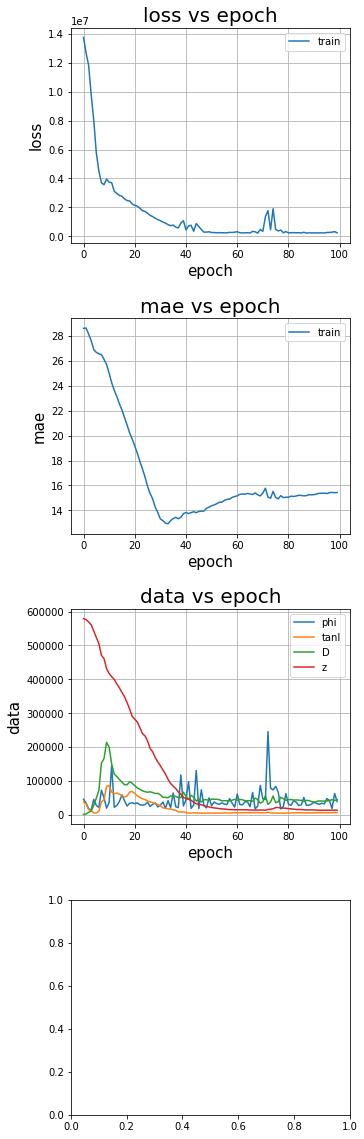

In [92]:
print(H.history.keys())
print("loss: ", H.history["loss"])
print("mae: ", H.history["mae"])
# print("val_loss: ", H.history["val_loss"])
# print("val_mae: ", H.history["val_mae"])

lim = 0

if len(H.history.keys()) > 4:
  fig, ax = plt.subplots(4,1,figsize=(5,20))
  fig.subplots_adjust(hspace=0.35)

  ax[0].plot(H.history["loss"][lim:])
  # ax[0].plot(H.history["val_loss"][lim:])
  ax[0].set_title("loss vs epoch", fontsize=20)
  ax[0].set_xlabel("epoch", fontsize=15)
  ax[0].set_ylabel("loss", fontsize=15)
  # ax[0].set_yscale("log")
  ax[0].legend(["train","val"])
  ax[0].grid(True)


  ax[1].plot(H.history["mae"][lim:])
  # ax[1].plot(H.history["val_mae"][lim:])
  ax[1].set_title("mae vs epoch", fontsize=20)
  ax[1].set_xlabel("epoch", fontsize=15)
  ax[1].set_ylabel("mae", fontsize=15)
  ax[1].legend(["train","val"])
  ax[1].grid(True)

  # ax[2].plot(H.history["q_pt"][lim:])
  ax[2].plot(H.history["phi"][lim:])
  ax[2].plot(H.history["tanl"][lim:])
  ax[2].plot(H.history["D"][lim:])
  ax[2].plot(H.history["z"][lim:])
  ax[2].set_title("data vs epoch", fontsize=20)
  ax[2].set_xlabel("epoch", fontsize=15)
  ax[2].set_ylabel("data", fontsize=15)
  # ax[2].legend(["q_pt","phi","tanl","D","z"])
  ax[2].legend(["phi","tanl","D","z"])
  # ax[2].legend(["phi","D","z"])
  ax[2].grid(True)

  # ax[3].plot(H.history["val_q_pt"][lim:])
  ax[3].plot(H.history["val_phi"][lim:])
  ax[3].plot(H.history["val_tanl"][lim:])
  ax[3].plot(H.history["val_D"][lim:])
  ax[3].plot(H.history["val_z"][lim:])
  ax[3].set_title("data vs epoch", fontsize=20)
  ax[3].set_xlabel("epoch", fontsize=15)
  ax[3].set_ylabel("data", fontsize=15)
  # ax[3].legend(["val_q_pt","val_phi","val_tanl","val_D","val_z"])
  ax[3].legend(["val_phi","val_tanl","val_D","val_z"])
  # ax[3].legend(["val_phi","val_D","val_z"])
  ax[3].grid(True)

else:
  fig, ax = plt.subplots(2,1,figsize=(5,10))
  fig.subplots_adjust(hspace=0.35)

  ax[0].plot(H.history["loss"][lim:])
  # ax[0].plot(H.history["val_loss"][lim:])
  ax[0].set_title("loss vs epoch", fontsize=20)
  ax[0].set_xlabel("epoch", fontsize=15)
  ax[0].set_ylabel("loss", fontsize=15)
  # ax[0].set_yscale("log")
  ax[0].legend(["train","val"])
  ax[0].grid(True)


  ax[1].plot(H.history["mae"][lim:])
  # ax[1].plot(H.history["val_mae"][lim:])
  ax[1].set_title("mae vs epoch", fontsize=20)
  ax[1].set_xlabel("epoch", fontsize=15)
  ax[1].set_ylabel("mae", fontsize=15)
  ax[1].legend(["train","val"])
  ax[1].grid(True)


dict_keys(['loss', 'mae'])
loss:  [126944.15625, 125522.3984375, 124109.0546875, 122704.2421875, 121308.1015625, 119920.734375, 118542.296875, 117172.9140625, 115812.6953125, 114461.796875, 113120.296875, 111788.3046875, 110465.9296875, 109153.2890625, 107850.4453125, 106557.4921875, 105274.5546875, 104001.6484375, 102738.8984375, 101486.3046875, 100243.9921875, 99011.9765625, 97790.296875, 96579.0546875, 95378.234375, 94187.8671875, 93007.9921875, 91838.6484375, 90679.8203125, 89531.53125, 88393.8125, 87266.6640625, 86150.0546875, 85043.9609375, 83948.4375, 82863.4296875, 81788.9375, 80724.9375, 79671.390625, 78628.3046875, 77595.609375, 76573.28125, 75561.328125, 74559.640625, 73568.2421875, 72587.078125, 71616.0859375, 70655.21875, 69704.4609375, 68763.75, 67833.0078125, 66912.2109375, 66001.3203125, 65100.234375, 64208.93359375, 63327.3671875, 62455.44140625, 61593.12890625, 60740.3671875, 59897.09375, 59063.25, 58238.7421875, 57423.5625, 56617.60546875, 55820.84375, 55033.1796875,

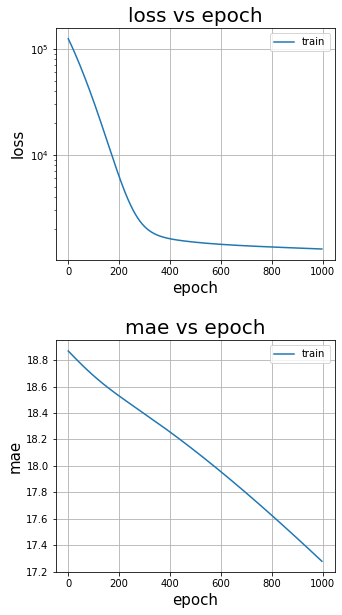

In [ ]:
print(H.history.keys())
print("loss: ", H.history["loss"])
print("mae: ", H.history["mae"])
# print("val_loss: ", H.history["val_loss"])
# print("val_mae: ", H.history["val_mae"])

lim = 2

fig, ax = plt.subplots(2,1,figsize=(5,10))
fig.subplots_adjust(hspace=0.35)

ax[0].plot(H.history["loss"][lim:])
# ax[0].plot(H.history["val_loss"][lim:])
ax[0].set_title("loss vs epoch", fontsize=20)
ax[0].set_xlabel("epoch", fontsize=15)
ax[0].set_ylabel("loss", fontsize=15)
ax[0].set_yscale("log")
ax[0].legend(["train","val"])
ax[0].grid(True)


ax[1].plot(H.history["mae"][lim:])
# ax[1].plot(H.history["val_mae"][lim:])
ax[1].set_title("mae vs epoch", fontsize=20)
ax[1].set_xlabel("epoch", fontsize=15)
ax[1].set_ylabel("mae", fontsize=15)
ax[1].legend(["train","val"])
ax[1].grid(True)


# Graphs

In [ ]:
# Maybe copy over previous function and edit that?
def graph(pred, true, diff):

  values = ["u","v","sin(v)","cos(v)","sin(u)","cos(u)","s","ds","wire","glayer","z","time","dE_amp","q"]
  limits = [["todo"]]

  size = len(values)

  fig, axs = plt.subplots(4,size,figsize=(size*5,20))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)


  for i in range(size):
    (mu, sigma) = norm.fit(diff[:,i])
    print("data" , values[i] ," |: mu: ", mu, "sigma: " , sigma)
    _, bins, _ = axs[0,i].hist(diff[:,i], 20, density=True)
    y = norm.pdf(bins, mu, sigma)
    l = axs[0,i].plot(bins, y, 'r--', linewidth=2)

    axs[0,i].set_title(values[i] + ' diff')
    axs[0,i].set_ylabel('freq')
    axs[0,i].set_xlabel(values[i] + ' diff')

  #--------------------------------------
  # PREDICTED VS TRUE
  #--------------------------------------
    
  for i in range(size):
    axs[1,i].scatter(true[:,i],pred[:,i])
    axs[1,i].grid(True)

    axs[1,i].set_title(values[i] + ' (predicted vs true)')
    axs[1,i].set_ylabel('pred ' + values[i])
    axs[1,i].set_xlabel('true ' + values[i])

    # axs[1,i].set_xlim(limits[i])
    # axs[1,i].set_ylim(limits[i])
    # axs[1,i].plot(limits[i],limits[i], color='b')

  #--------------------------------------
  # DIFFERENCE VS TRUE
  #--------------------------------------

  for i in range(size):
    axs[2,i].scatter(true[:,i],diff[:,i])
    l, r = axs[2,i].get_xlim()
    axs[2,i].hlines(0, l, r)
    axs[2,i].grid(True)

    axs[2,i].set_title(values[i] + ' (difference vs true)')
    axs[2,i].set_ylabel('diff ' + values[i])
    axs[2,i].set_xlabel('true ' + values[i])

  #--------------------------------------
  # DIFFERENCE VS TRUE 2D HIST
  #--------------------------------------

  for i in range(size):
    axs[3,i].hist2d(true[:,i],diff[:,i],bins=20)

    axs[2,i].set_title(values[i] + ' (difference vs true)')
    axs[2,i].set_ylabel('diff ' + values[i])
    axs[2,i].set_xlabel('true ' + values[i])

  fig.show()


In [ ]:
def gen_test_data(x_test, y_test, size=1000):
  pred = model.predict(x_test)
  diff = pred - y_test
  return pred, y_test, diff

In [ ]:
graph(gen_test_data(x_test, y_test));

# Test model

In [ ]:
# make test function

# Verification of proper data processing

## Using Generator

In [ ]:
aax, aay = next(train_gen)
print(aax.shape)
print(aay.shape)

In [ ]:
print("x",aax[0])
print("y",aay[0])

## Non Genenerator

In [ ]:
for i in range(10):
  aax = x_train[i]
  aay = y_train[i]
  # print(aax.shape)
  # print(aay.shape)
  # print("x",aax)
  print("y",aay)

y [-4.805 -1.959  9.798  0.297 77.505]
y [-5.881  1.876 19.786 -0.007 85.963]
y [-13.532   2.467   1.919  -5.848 169.211]
y [ -2.51   -1.784   7.588   0.107 138.047]
y [-17.129   1.434  26.423  -0.118  77.014]
y [-51.732  -0.04   20.991  -0.511  62.764]
y [ -7.787  -2.598   6.704  -9.91  168.021]
y [-755.88    -2.511   56.192  -11.262  177.016]
y [-9.942 -1.74   6.379  0.622 62.467]
y [-3.746  0.884 14.103 -0.305 66.462]


## Graphs of Data

### filter_ignore

Filters out large and small values and graphs them

In [ ]:
def filter_ignore(var,min=None,max=None,bins=25,ylog=False,xlog=False,cut=True):
  list_ignore = []

  print("--== {} ==--\n".format(var))

  largest = 0
  smallest = 0
  for i in range(len(csv_train[var])):
    if csv_train[var][i] > csv_train[var][largest]:
      largest = i
    if csv_train[var][i] < csv_train[var][smallest]:
      smallest = i
  print("largest value:  ({}, {:.3f})".format(largest,csv_train[var][largest]))
  print("smallest value: ({}, {:.3f})".format(smallest,csv_train[var][smallest]))

  print("")

  if min:
    for i in range(len(csv_train[var])):
      if csv_train[var][i] < min:
        list_ignore.append(i)
    print("min IDs to ignore for '{}':".format(var))
    print(csv_train[var][list_ignore])
    print("")
  if max:
    for i in range(len(csv_train[var])):
      if csv_train[var][i] > max:
        list_ignore.append(i)
    print("max IDs to ignore for '{}':".format(var))
    print(csv_train[var][list_ignore])
    print("")
  if min and max:
    print("total IDs to ignore for '{}':".format(var))
    print(csv_train[var][list_ignore])
    print("")
    plt.hist(csv_train[var],range=[min,max],bins=bins)
  elif min:
    plt.hist(csv_train[var],range=[min,csv_train[var][largest]],bins=bins)
  elif max:
    plt.hist(csv_train[var],range=[csv_train[var][smallest],max],bins=bins)
  else:
    plt.hist(csv_train[var],bins=bins)
  
  plt.title(var)
  if cut:
    plt.xlim(left=min,right=max)
  if ylog:
    plt.yscale("log")
  if xlog:
    plt.xscale("log")
  plt.show()
  return list_ignore

--== q_over_pt ==--

largest value:  (3355, 381.860)
smallest value: (9135, -20149.830)

min IDs to ignore for 'q_over_pt':
1317    -4724.393347
1481    -7912.062393
3410    -7389.880383
8777    -9841.475468
9135   -20149.829875
9584    -5357.554147
Name: q_over_pt, dtype: float64



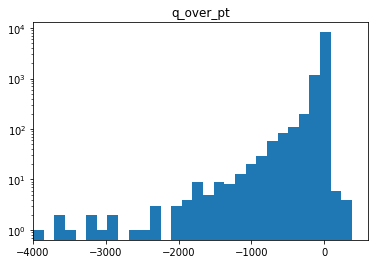

[1317, 1481, 3410, 8777, 9135, 9584]

In [ ]:
filter_ignore("q_over_pt",min=-4000,bins=30,ylog=True)

--== tanl ==--

largest value:  (9135, 1908.868)
smallest value: (2535, 0.001)

max IDs to ignore for 'tanl':
9135    1908.868217
Name: tanl, dtype: float64



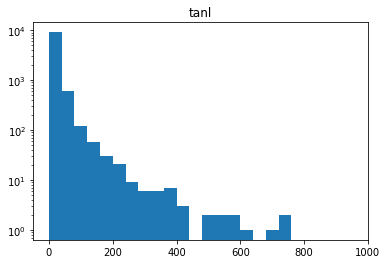

[9135]

In [ ]:
filter_ignore("tanl",max=1000,bins=25,ylog=True)

In [ ]:
rms_ignore = filter_ignore("rms",max=0.1,bins=25,ylog=True)

--== z ==--

largest value:  (5317, 340.485)
smallest value: (1775, -101.769)



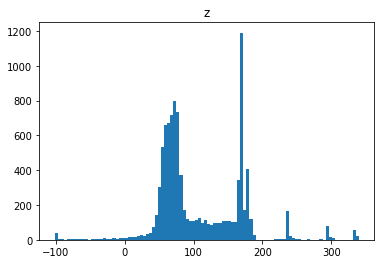

[]

In [ ]:
# 'q_over_pt', 'phi', 'tanl', 'D', 'z'
# filter_ignore("D", min=-200, ylog=True,bins=25)
filter_ignore("z",bins=100)

In [ ]:
csv_train.keys()

### 1D Hist of all Data

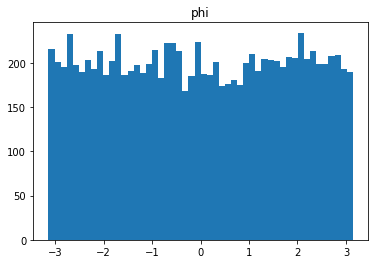

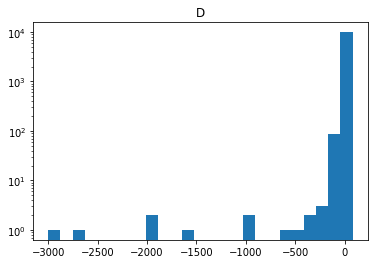

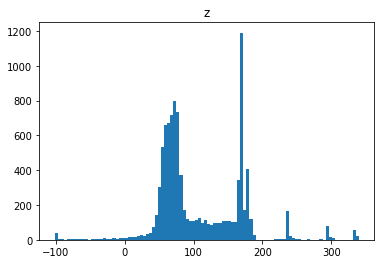

In [ ]:
plt.hist(csv_train["phi"],bins=50) # -3 to 3, even distrib
plt.title("phi")
plt.show()
# ---
plt.hist(csv_train["D"],range=[-3000,80],bins=25) # -3000 to 50, but val in 65
plt.yscale("log")
plt.title("D")
plt.show()
# ---
plt.hist(csv_train["z"],bins=100)
plt.title("z")
plt.show()

In [ ]:
# fig, ax = plt.subplots(2,1,figsize=(5,10))
# fig.subplots_adjust(hspace=0.35)

plt.hist(csv_train["cov_00"],range=[0,1e8],bins=25) # 0 to 1e13
plt.yscale("log")
plt.title("cov_00")
plt.show()
# ---
plt.hist(csv_train["cov_01"],bins=25) # -1e6 to over 1e5
plt.yscale("log")
plt.title("cov_01")
plt.show()
# ---
plt.hist(csv_train["chisq"],bins=25) # 0 to 200
plt.yscale("log")
plt.title("chisq")
plt.show()
# ---
plt.hist(csv_train["Ndof"],range=[0,44],bins=45) # ? this one weird 0 to ~43
plt.yscale("log")
plt.title("Ndof")
plt.show()
# ---
plt.hist(csv_train["rms"],range=[0,0.1],bins=25) # 
# plt.xscale("log")
plt.yscale("log")
plt.title("rms")
plt.show()
# ---
# plt.hist(csv_train["t_start_cntr"],bins=25) # -60 to ~50
plt.hist(csv_train[csv_train["t_start_cntr_valid"] == 1]["t_start_cntr"],bins=25) # -60 to ~50
plt.title("t_start_cntr")
plt.show()

# plt.hist(csv_train["t_tof"],bins=25) # ~-120 to ~175
plt.hist(csv_train[csv_train["t_tof_valid"] == 1]["t_tof"],bins=25) # ~-120 to ~175
plt.title("t_tof")
plt.show()
plt.hist(csv_train["t_bcal"],bins=25) # ~-22 to 20
plt.title("t_bcal")
plt.show()
plt.hist(csv_train["t_fcal"],bins=25) # ~-100 to ~75
plt.yscale("log")
plt.title("t_fcal")
plt.show()
# ---
plt.hist(csv_train["t_start_cntr_valid"],bins=25) # a lot more 0s
plt.title("t_start_cntr_valid")
plt.show()
plt.hist(csv_train["t_tof_valid"],bins=25) # about 5050
plt.title("t_tof_valid")
plt.show()
plt.hist(csv_train["t_bcal_valid"],bins=25) # almost all 0s
plt.title("t_bcal_valid")
plt.show()
plt.hist(csv_train["t_fcal_valid"],bins=25) # almost all 0s
plt.title("t_fcal_valid")
plt.show()
# ---



### 1D Hist of Hit1 Data

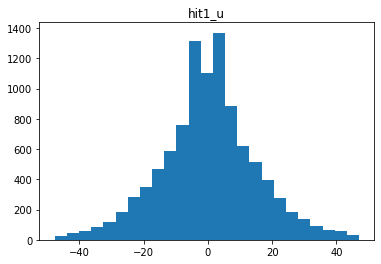

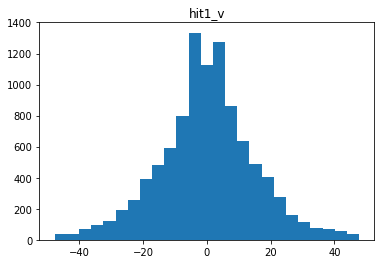

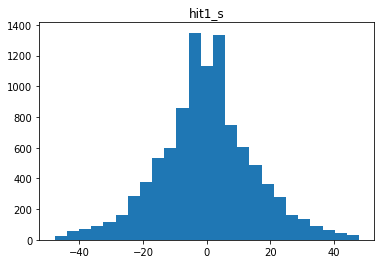

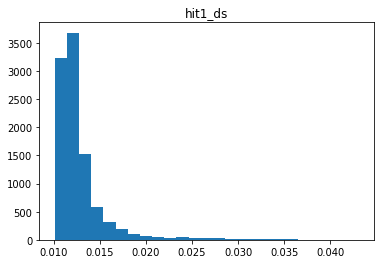

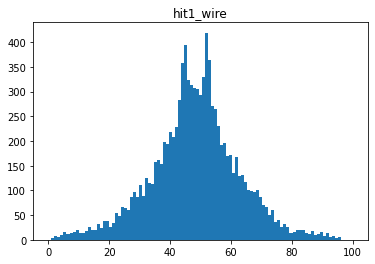

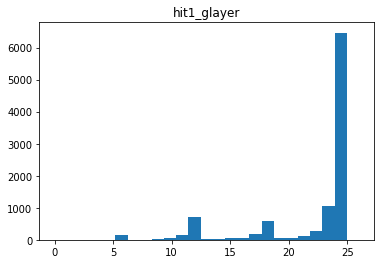

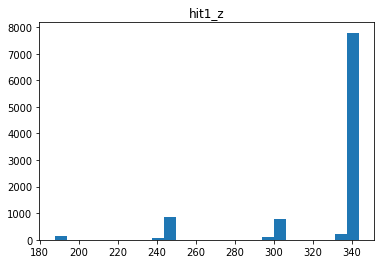

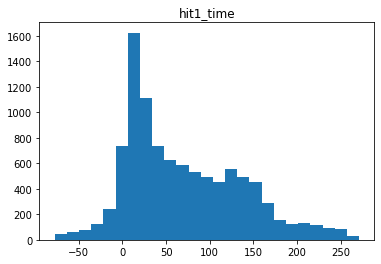

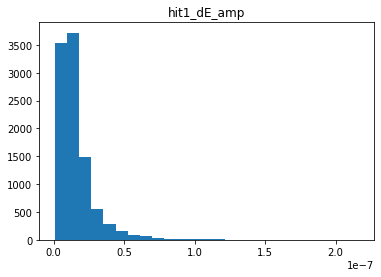

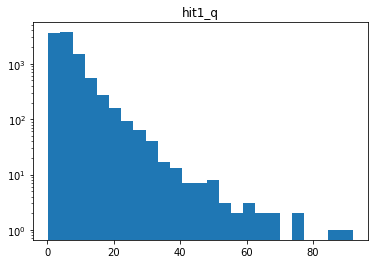

In [ ]:
plt.hist(csv_train["hit1_u"],bins=25) # -42 to 42
plt.title("hit1_u")
plt.show()
plt.hist(csv_train["hit1_v"],bins=25) # -42 to 42
plt.title("hit1_v")
plt.show()
# plt.hist(csv_train["hit1_sinv"],bins=25) # most are 0.96603 almost all are around that though
# plt.title("hit1_sinv")
# plt.show()
# plt.hist(csv_train["hit1_cosv"],bins=25) # most -0.2585
# plt.title("hit1_cosv")
# plt.show()
# plt.hist(csv_train["hit1_sinu"],bins=25) # most 0.96585
# plt.title("hit1_sinu")
# plt.show()
# plt.hist(csv_train["hit1_cosu"],bins=25) # most 0.2591
# plt.title("hit1_cosu")
# plt.show()
plt.hist(csv_train["hit1_s"],bins=25) # -42 to 42
plt.title("hit1_s")
plt.show()
plt.hist(csv_train["hit1_ds"],bins=25) # 0.01 to 0.04
plt.title("hit1_ds")
plt.show()
plt.hist(csv_train["hit1_wire"],bins=101,range=[0,100]) # 0 to 100
plt.title("hit1_wire")
plt.show()
plt.hist(csv_train["hit1_glayer"],bins=25,range=[0,26]) # 6 to 23
plt.title("hit1_glayer")
plt.show()
plt.hist(csv_train["hit1_z"],bins=25) # spaced out between 180 and 340
plt.title("hit1_z")
plt.show()
plt.hist(csv_train["hit1_time"],bins=25) # -75 to 270
plt.title("hit1_time")
plt.show()
plt.hist(csv_train["hit1_dE_amp"],bins=25) # 0 to 2e-7
plt.title("hit1_dE_amp")
plt.show()
plt.hist(csv_train["hit1_q"],bins=25) # 0 to 85
plt.yscale("log")
plt.title("hit1_q")
plt.show()
# ---

### 2D Scatters of various data

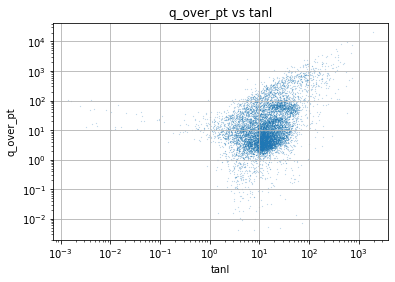

In [ ]:
plt.scatter(csv_train["tanl"],abs(csv_train["q_over_pt"]),s=0.01) # a lot more 0s
plt.title("q_over_pt vs tanl")
plt.xlabel("tanl")
plt.ylabel("q_over_pt")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.show()

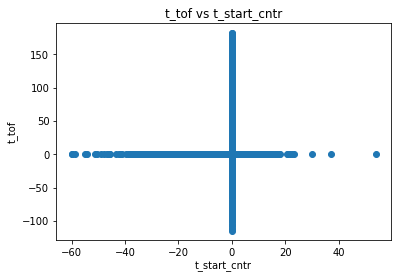

In [ ]:
# all create a plus sign
plt.scatter(csv_train["t_start_cntr"],csv_train["t_tof"]) # a lot more 0s
plt.title("t_tof vs t_start_cntr")
plt.xlabel("t_start_cntr")
plt.ylabel("t_tof")
plt.show()

# plt.hist(csv_train["t_start_cntr"],bins=25) # -60 to ~50
# plt.hist(csv_train["t_tof"],bins=25) # ~-120 to ~175
# plt.hist(csv_train["t_bcal"],bins=25) # ~-22 to 20
# plt.hist(csv_train["t_fcal"],bins=25) # ~-100 to ~75

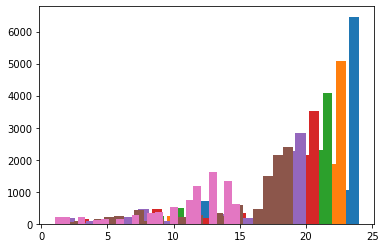

In [ ]:
plt.hist(csv_train["hit1_glayer"],bins=24)
plt.hist(csv_train["hit2_glayer"],bins=24)
plt.hist(csv_train["hit3_glayer"],bins=24)
plt.hist(csv_train["hit4_glayer"],bins=24)
plt.hist(csv_train["hit5_glayer"],bins=24)
plt.hist(csv_train["hit6_glayer"],bins=24)
plt.hist(csv_train["hit10_glayer"],bins=24)
plt.show()

### 2D Scatters of various hit data

In [ ]:
# Oval
plt.scatter(csv_train["hit1_u"],csv_train["hit1_v"]) # -3 to 3, even distrib
plt.title("v vs u")
plt.xlabel("u")
plt.ylabel("v")
plt.show()

# like a flame
plt.scatter(csv_train["hit1_s"],csv_train["hit1_ds"]) # -3 to 3, even distrib
plt.title("ds vs s")
plt.xlabel("s")
plt.ylabel("ds")
plt.show()

# hit1_wire, with single letters, forms an oval
plt.scatter(csv_train["hit1_wire"],csv_train["hit1_s"]) # -3 to 3, even distrib
plt.title("hit1_s vs hit1_wire")
plt.xlabel("hit1_wire")
plt.ylabel("hit1_s")
plt.show()

# go up in steps
plt.scatter(csv_train["hit1_glayer"],csv_train["hit1_z"]) # -3 to 3, even distrib
plt.title("z vs glayer")
plt.xlabel("glayer")
plt.ylabel("z")
plt.show()

# 1:1
plt.scatter(csv_train["hit1_q"],csv_train["hit1_dE_amp"]) # -3 to 3, even distrib
plt.title("dE_amp vs q")
plt.xlabel("q")
plt.ylabel("dE_amp")
plt.show()



In [ ]:
aax = 
plt.plot()